In [1]:
# ============================
# 1. Imports
# ============================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
# ============================
# 2. Dataset & DataLoaders (InceptionV3 / InceptionV4)
# ============================
data_dir = "/kaggle/input/new-dataset-cucumber-disease-8-classes/New data set"

import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision import datasets

# Train / Val / Test transforms (Inception expects 299x299)
train_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load dataset (initially with train_transform)
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
class_names = full_dataset.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Total Images:", len(full_dataset))

# Split dataset: 80% train, 10% val, 10% test
train_size = int(0.8 * len(full_dataset))
val_size   = int(0.1 * len(full_dataset))
test_size  = len(full_dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])

# Override transforms for val/test
val_ds.dataset.transform = val_transform
test_ds.dataset.transform = val_transform

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)


Classes: ['Anthracnose', 'Bacterial Wilt', 'Belly Rot', 'Downy Mildew', 'Fresh Cucumber', 'Fresh Leaf', 'Gummy Stem Blight', 'Pythium Fruit Rot']
Total Images: 1289


In [3]:
# ============================
# 2. Dataset & DataLoaders (InceptionV3 / InceptionV4)
# ============================
data_dir = "/kaggle/input/new-dataset-cucumber-disease-8-classes/New data set"

import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision import datasets

# Train / Val / Test transforms (Inception expects 299x299)
train_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load dataset (initially with train_transform)
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
class_names = full_dataset.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Total Images:", len(full_dataset))

# Split dataset: 80% train, 10% val, 10% test
train_size = int(0.8 * len(full_dataset))
val_size   = int(0.1 * len(full_dataset))
test_size  = len(full_dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])

# Override transforms for val/test
val_ds.dataset.transform = val_transform
test_ds.dataset.transform = val_transform

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)


Classes: ['Anthracnose', 'Bacterial Wilt', 'Belly Rot', 'Downy Mildew', 'Fresh Cucumber', 'Fresh Leaf', 'Gummy Stem Blight', 'Pythium Fruit Rot']
Total Images: 1289


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm  # make sure timm is installed

# Suppose class_names is defined earlier
num_classes = len(class_names)

# -----------------------------
# Load InceptionV4 model (via timm)
# -----------------------------
model = timm.create_model('inception_v4', pretrained=False, num_classes=1000)

# Replace final classification head
in_features = model.last_linear.in_features
model.last_linear = nn.Linear(in_features, num_classes)

# Send to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# -----------------------------
# Loss, optimizer
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 15


In [5]:
from tqdm.auto import tqdm

# ============================
# Training & Validation Loop (InceptionV3)
# ============================
num_epochs = 20
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # ---- Training ----
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    train_bar = tqdm(train_loader, desc=f"Train {epoch+1}/{num_epochs}", leave=False)

    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # InceptionV3 outputs
        if isinstance(outputs, tuple) or hasattr(outputs, "logits"):
            main_output = outputs.logits if hasattr(outputs, "logits") else outputs[0]
            aux_output  = outputs.aux_logits if hasattr(outputs, "aux_logits") else outputs[1]

            loss1 = criterion(main_output, labels)
            loss2 = criterion(aux_output, labels) * 0.4  # auxiliary loss
            loss = loss1 + loss2
            preds = main_output.argmax(1)
        else:
            loss = criterion(outputs, labels)
            preds = outputs.argmax(1)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        train_bar.set_postfix(loss=loss.item())

    train_loss = running_loss / total
    train_acc = 100 * correct / total

    # ---- Validation ----
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    val_bar = tqdm(val_loader, desc=f"Val {epoch+1}/{num_epochs}", leave=False)

    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Only use main logits
            outputs = outputs.logits if hasattr(outputs, "logits") else outputs
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            val_bar.set_postfix(loss=loss.item())

    val_loss /= val_total
    val_acc = 100 * val_correct / val_total

    # ---- Save history ----
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    # ---- Epoch summary ----
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss={train_loss:.4f}, Acc={train_acc:.2f}% | "
          f"Val Loss={val_loss:.4f}, Acc={val_acc:.2f}%")



Epoch 1/20


Train 1/20:   0%|          | 0/33 [00:00<?, ?it/s]

Val 1/20:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss=1.7162, Acc=35.98% | Val Loss=2.7525, Acc=16.41%

Epoch 2/20


Train 2/20:   0%|          | 0/33 [00:00<?, ?it/s]

Val 2/20:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss=1.0656, Acc=60.23% | Val Loss=1.0267, Acc=64.06%

Epoch 3/20


Train 3/20:   0%|          | 0/33 [00:00<?, ?it/s]

Val 3/20:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss=0.8724, Acc=67.80% | Val Loss=1.2871, Acc=57.81%

Epoch 4/20


Train 4/20:   0%|          | 0/33 [00:00<?, ?it/s]

Val 4/20:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss=0.8614, Acc=65.66% | Val Loss=0.7851, Acc=64.84%

Epoch 5/20


Train 5/20:   0%|          | 0/33 [00:00<?, ?it/s]

Val 5/20:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss=0.8112, Acc=70.13% | Val Loss=0.9304, Acc=64.06%

Epoch 6/20


Train 6/20:   0%|          | 0/33 [00:00<?, ?it/s]

Val 6/20:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss=0.7795, Acc=69.45% | Val Loss=1.1049, Acc=62.50%

Epoch 7/20


Train 7/20:   0%|          | 0/33 [00:00<?, ?it/s]

Val 7/20:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss=0.6582, Acc=73.81% | Val Loss=1.0092, Acc=67.97%

Epoch 8/20


Train 8/20:   0%|          | 0/33 [00:00<?, ?it/s]

Val 8/20:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss=0.7297, Acc=72.16% | Val Loss=0.8533, Acc=64.84%

Epoch 9/20


Train 9/20:   0%|          | 0/33 [00:00<?, ?it/s]

Val 9/20:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss=0.6835, Acc=73.04% | Val Loss=0.8118, Acc=68.75%

Epoch 10/20


Train 10/20:   0%|          | 0/33 [00:00<?, ?it/s]

Val 10/20:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss=0.5998, Acc=78.08% | Val Loss=0.6563, Acc=74.22%

Epoch 11/20


Train 11/20:   0%|          | 0/33 [00:00<?, ?it/s]

Val 11/20:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss=0.5444, Acc=80.31% | Val Loss=0.7105, Acc=71.88%

Epoch 12/20


Train 12/20:   0%|          | 0/33 [00:00<?, ?it/s]

Val 12/20:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss=0.4449, Acc=83.80% | Val Loss=0.7716, Acc=74.22%

Epoch 13/20


Train 13/20:   0%|          | 0/33 [00:00<?, ?it/s]

Val 13/20:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss=0.5399, Acc=80.70% | Val Loss=0.6788, Acc=77.34%

Epoch 14/20


Train 14/20:   0%|          | 0/33 [00:00<?, ?it/s]

Val 14/20:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss=0.5273, Acc=80.60% | Val Loss=0.7157, Acc=74.22%

Epoch 15/20


Train 15/20:   0%|          | 0/33 [00:00<?, ?it/s]

Val 15/20:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss=0.4213, Acc=84.29% | Val Loss=0.7282, Acc=75.00%

Epoch 16/20


Train 16/20:   0%|          | 0/33 [00:00<?, ?it/s]

Val 16/20:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss=0.3846, Acc=86.03% | Val Loss=0.7125, Acc=73.44%

Epoch 17/20


Train 17/20:   0%|          | 0/33 [00:00<?, ?it/s]

Val 17/20:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss=0.4322, Acc=85.35% | Val Loss=0.6499, Acc=76.56%

Epoch 18/20


Train 18/20:   0%|          | 0/33 [00:00<?, ?it/s]

Val 18/20:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss=0.3671, Acc=87.49% | Val Loss=0.6151, Acc=74.22%

Epoch 19/20


Train 19/20:   0%|          | 0/33 [00:00<?, ?it/s]

Val 19/20:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss=0.3141, Acc=89.23% | Val Loss=0.7052, Acc=78.12%

Epoch 20/20


Train 20/20:   0%|          | 0/33 [00:00<?, ?it/s]

Val 20/20:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss=0.3039, Acc=89.43% | Val Loss=0.7531, Acc=77.34%


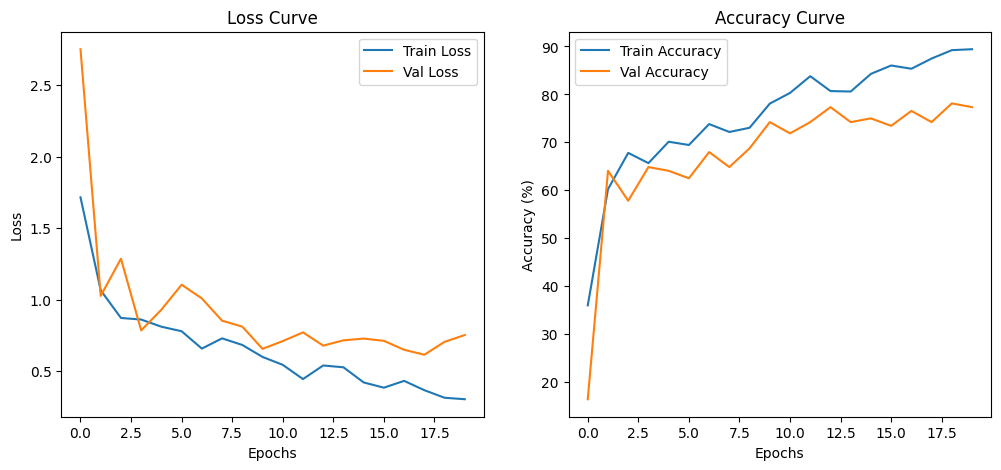

In [6]:
# ============================
# 6. Plot Training Curves
# ============================

import matplotlib.pyplot as plt   # ✅ Correct import

plt.figure(figsize=(12,5))

# Loss curves
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

# Accuracy curves
plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy Curve")

plt.show()


Testing:   0%|          | 0/5 [00:00<?, ?it/s]


Classification Report:
                   precision    recall  f1-score   support

      Anthracnose       0.25      0.17      0.20        18
   Bacterial Wilt       0.71      0.83      0.77        12
        Belly Rot       1.00      1.00      1.00        15
     Downy Mildew       0.67      0.38      0.48        16
   Fresh Cucumber       1.00      1.00      1.00        21
       Fresh Leaf       0.64      0.94      0.76        17
Gummy Stem Blight       0.61      0.73      0.67        15
Pythium Fruit Rot       0.94      0.94      0.94        16

         accuracy                           0.75       130
        macro avg       0.73      0.75      0.73       130
     weighted avg       0.73      0.75      0.73       130



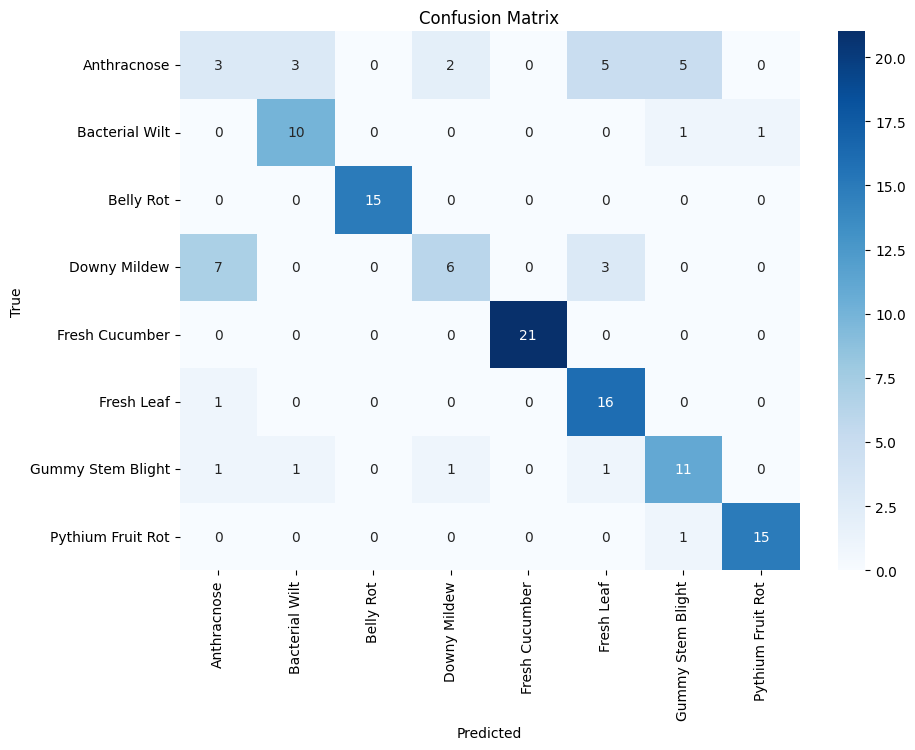

In [7]:
# ============================
# 7. Testing & Evaluation
# ============================
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
